In [3]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt

In [4]:
# Read the CSV file into the DataFrame
df = pd.read_csv("D:\shared_git\MaestriaThesis\FeaturesTabs\pp01_t7.csv")

# Rename the first four columns
new_column_names = ['channels', 'ID', 'Type', 'Epoch']
df.rename(columns=dict(zip(df.columns[:4], new_column_names)), inplace=True)

filtered_class_labels = df[df['channels'] == 5]
filtered_class_labels = filtered_class_labels.drop(columns=['ID'])
filtered_class_labels = filtered_class_labels.drop(columns=['channels', 'Epoch'])
filtered_class_labels = filtered_class_labels.reset_index(drop=True)

# Extract the next 1000 columns as an array
data_array = filtered_class_labels.iloc[:, 4:].values
class_labels = filtered_class_labels.iloc[:,0]

print(class_labels)

0       12
1       12
2       12
3       12
4       12
        ..
7542     5
7543     5
7544     5
7545     5
7546     5
Name: Type, Length: 7547, dtype: int64


In [5]:
mods = class_labels.copy() 
mod = ['Air', 'Vib', 'Car']
mods[(4 >= class_labels)] = mod[0]
mods[(5 <= class_labels) & (8 >= class_labels)] = mod[1]
mods[(9 <= class_labels) & (12 <= class_labels)] = mod[2]

print(mods.head(7000)) 
class_labels = (class_labels - 1) % 4 + 1 

0       Car
1       Car
2       Car
3       Car
4       Car
       ... 
6995    Vib
6996    Vib
6997    Vib
6998    Vib
6999    Vib
Name: Type, Length: 7000, dtype: object


In [6]:
lowcut = 2.0  
highcut = 30.0  
fs_original = 250.0  
fs_downsampled = 60 

nyquist = 0.5 * fs_original
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

filtered_data_array = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=1, arr=data_array)

downsample_factor = int(fs_original / fs_downsampled)
downsampled_data_array = resample(filtered_data_array, len(filtered_data_array[0]) // downsample_factor, axis=1)

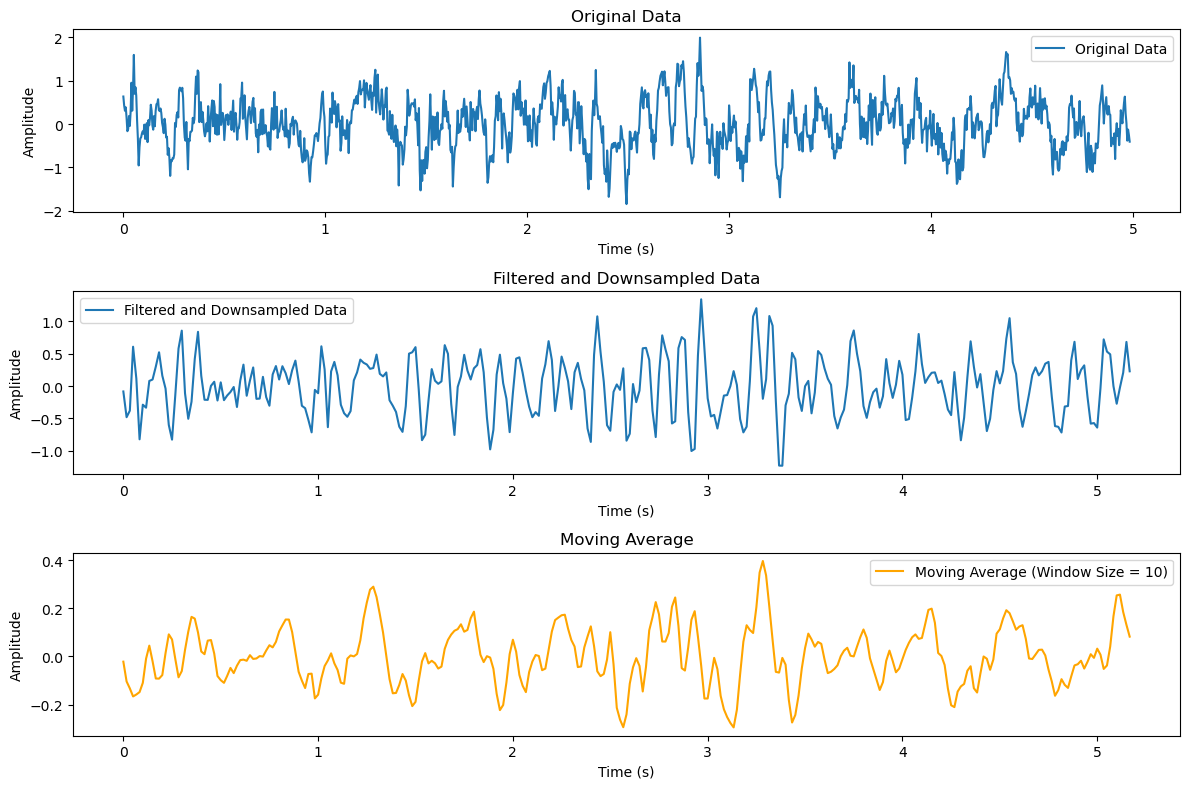

In [10]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt

row_index = 0
original_row = data_array[row_index, :]
filtered_row = filtered_data_array[row_index, :]
downsampled_row = downsampled_data_array[row_index, :]

window_size = 10
moving_average_row = np.convolve(downsampled_row, np.ones(window_size)/window_size, mode='same')

time_original = np.arange(0, len(original_row)) / fs_original

time_downsampled = np.arange(0, len(downsampled_row)) / fs_downsampled

time_moving_average = np.arange(0, len(moving_average_row)) / fs_downsampled

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time_original, original_row, label='Original Data')
plt.title('Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_downsampled, downsampled_row, label='Filtered and Downsampled Data')
plt.title('Filtered and Downsampled Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_moving_average, moving_average_row, label=f'Moving Average (Window Size = {window_size})', color='orange')
plt.title('Moving Average')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Create a DataFrame with the downsampled data and class labels
combined_df = pd.concat([mods, pd.DataFrame(downsampled_data_array)], axis=1)

print(combined_df)

     Type         0         1         2         3         4         5  \
0     Car -0.083052 -0.480449 -0.379431  0.607726  0.117622 -0.821779   
1     Car  0.081215  0.441704  0.618521  0.710653  0.393286  0.356047   
2     Car  0.066214  0.165101  0.468585 -0.114062 -0.246205  0.057384   
3     Car -0.074127  0.062630 -0.100886  0.213431  0.296112 -0.045407   
4     Car  0.015577  0.156957  0.115703  0.496034  0.171299 -0.191284   
...   ...       ...       ...       ...       ...       ...       ...   
7542  Vib -0.021060 -0.709181 -1.020905 -0.810739 -0.404640  0.052360   
7543  Vib -0.048989  0.021482  0.685372  0.104992  0.077608  0.634423   
7544  Vib -0.085707 -0.929847  0.038839 -0.139873 -0.344564 -0.584754   
7545  Vib -0.181332 -1.240730 -1.325969 -1.604557 -1.486356 -0.479142   
7546  Vib -0.229639  0.014136 -0.094201  0.023032  0.028870 -0.941892   

             6         7         8  ...       301       302       303  \
0    -0.287363 -0.333543  0.079463  ... -0.032568 

In [9]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Select features (X) and target variable (y)
X = downsampled_data_array  # Assuming the downsampled data starts from the 5th column
y = class_labels.values  # Assuming 'channels' is the target variable

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=12)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 24.97%


In [11]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute mutual information scores
mutual_info_scores = mutual_info_classif(X_train, y_train)

# Display mutual information scores for each feature
for feature, score in zip(range(X_train.shape[1]), mutual_info_scores):
    print(f"Feature index: {feature}, Mutual Information Score: {score}")

# Choose a threshold for feature selection based on mutual information
threshold = 0.0001  # You can adjust this threshold based on your preference

# Select features above the threshold
selected_features = np.where(mutual_info_scores > threshold)[0]

# Subset the original data with the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train a model using the selected features
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with selected features: {accuracy * 100:.2f}%")

Feature index: 0, Mutual Information Score: 0.0
Feature index: 1, Mutual Information Score: 0.007723670670824134
Feature index: 2, Mutual Information Score: 0.0
Feature index: 3, Mutual Information Score: 0.0
Feature index: 4, Mutual Information Score: 0.009157994908308709
Feature index: 5, Mutual Information Score: 0.0
Feature index: 6, Mutual Information Score: 0.0
Feature index: 7, Mutual Information Score: 0.0
Feature index: 8, Mutual Information Score: 0.0018097015806937122
Feature index: 9, Mutual Information Score: 0.0
Feature index: 10, Mutual Information Score: 0.010600063590704867
Feature index: 11, Mutual Information Score: 0.0
Feature index: 12, Mutual Information Score: 0.003750043942539971
Feature index: 13, Mutual Information Score: 0.0
Feature index: 14, Mutual Information Score: 0.0
Feature index: 15, Mutual Information Score: 0.005967614184715586
Feature index: 16, Mutual Information Score: 0.014261186519242575
Feature index: 17, Mutual Information Score: 0.0012018630